### Imports

In [1]:
from tensorflow_addons.layers import SpectralNormalization as SN # spectral normalization is used in Real-ESRGAN
from tensorflow.keras.models import Model, load_model, clone_model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, UpSampling2D # layers used in model
from tensorflow.keras.optimizers import Adam
from PIL import Image # load 'em image files
import tensorflow.keras.backend as K # getting/setting the weights for the VGG feature extractor
import matplotlib.pyplot as plt # plotting utilities
import tensorflow.keras.applications as kapp # VGG19 utilities
import tensorflow as tf # more math-focused operations like ReLU
import numpy as np # linear algebra
import random
import time
import glob # getting complete input filepaths for building the dataset 
import os # basic file navigation

### Hyperparameters

In [2]:
TRAIN_GAN = True
PRETRAINED_MODEL = True
PRETRAINED_GAN = True
BATCH_SIZE = 16 if TRAIN_GAN else 32
EPOCHS = 50
CV_RATIO = 0.95 # proportion of the full dataset reserved for training, the rest is validation
FULL_IMG_SIZE = (720, 1280) # size of the input images as well as the images that we want to test our model's speed on
IMG_SIZE = (256, 256) # the size of the images used during training; we will take random crops of the full-sized (720p) imagees
DEG_DIR = '/kaggle/input/video-frame-restoration/deg' # parent path of the degraded input images
GT_DIR = '/kaggle/input/video-frame-restoration/gt' # parent path of the ground truth (GT) images

### Get File Paths For Dataset
Here is how I formatted my dataset. In the video-frame-restoration dataset, there is a 'deg'
folder containing degraded images that will be used as input for the model to restore.

Within that folder, there is an '*h264*' and '*vp9*' folder which correlates to images that were
compressed using those methods (these are the main video compression techniques in use).

Within those folders, there are subfolders that represent the constant rate factor (CRF; this is a guideline for the images to be
compressed such that it maintains a certain visual quality; lower being better and higher being worse) that I compressed the images with.

Inside those folders, there are the images that were extracted from the original data,
but were compressed based on the criteria provided within its parent folders' names.
Note that these images are in the same alphabetical order as the ground truth images,
which we will use to pair up the input images from all compression methods and scales
with the appropriate restored image.

In [3]:
# get all of the input images
# 1st * = get folders with h264 and vp9 compression
# 2nd * = get folders from all compression qualities
# 3rd * = get all files from the folders collected from the 1st and 2nd stars
input_img_paths = sorted(glob.glob(f'{DEG_DIR}/*/*/*'))

# get all of the output images
target_img_paths = sorted(glob.glob(f'{GT_DIR}/*'))

m = len(target_img_paths) # the "true" number of unique images in the dataset (the input data contains a multiple of this amount)
num_copies = len(input_img_paths) // m # returns the number of compression types and scales were used to synthesize the input data from the target data

for i in range(10): # list first 10 input/target file paths
    print(f'Input image path: {input_img_paths[i]} | Target image path: {target_img_paths[i]}')
    
print("Number of input images:", len(input_img_paths))
print("Number of target images:", len(target_img_paths))

Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00001.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00000.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00002.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00001.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00003.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00002.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00004.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00003.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00005.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00004.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00006.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00005.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00007.jpg |

### View Some Input Images

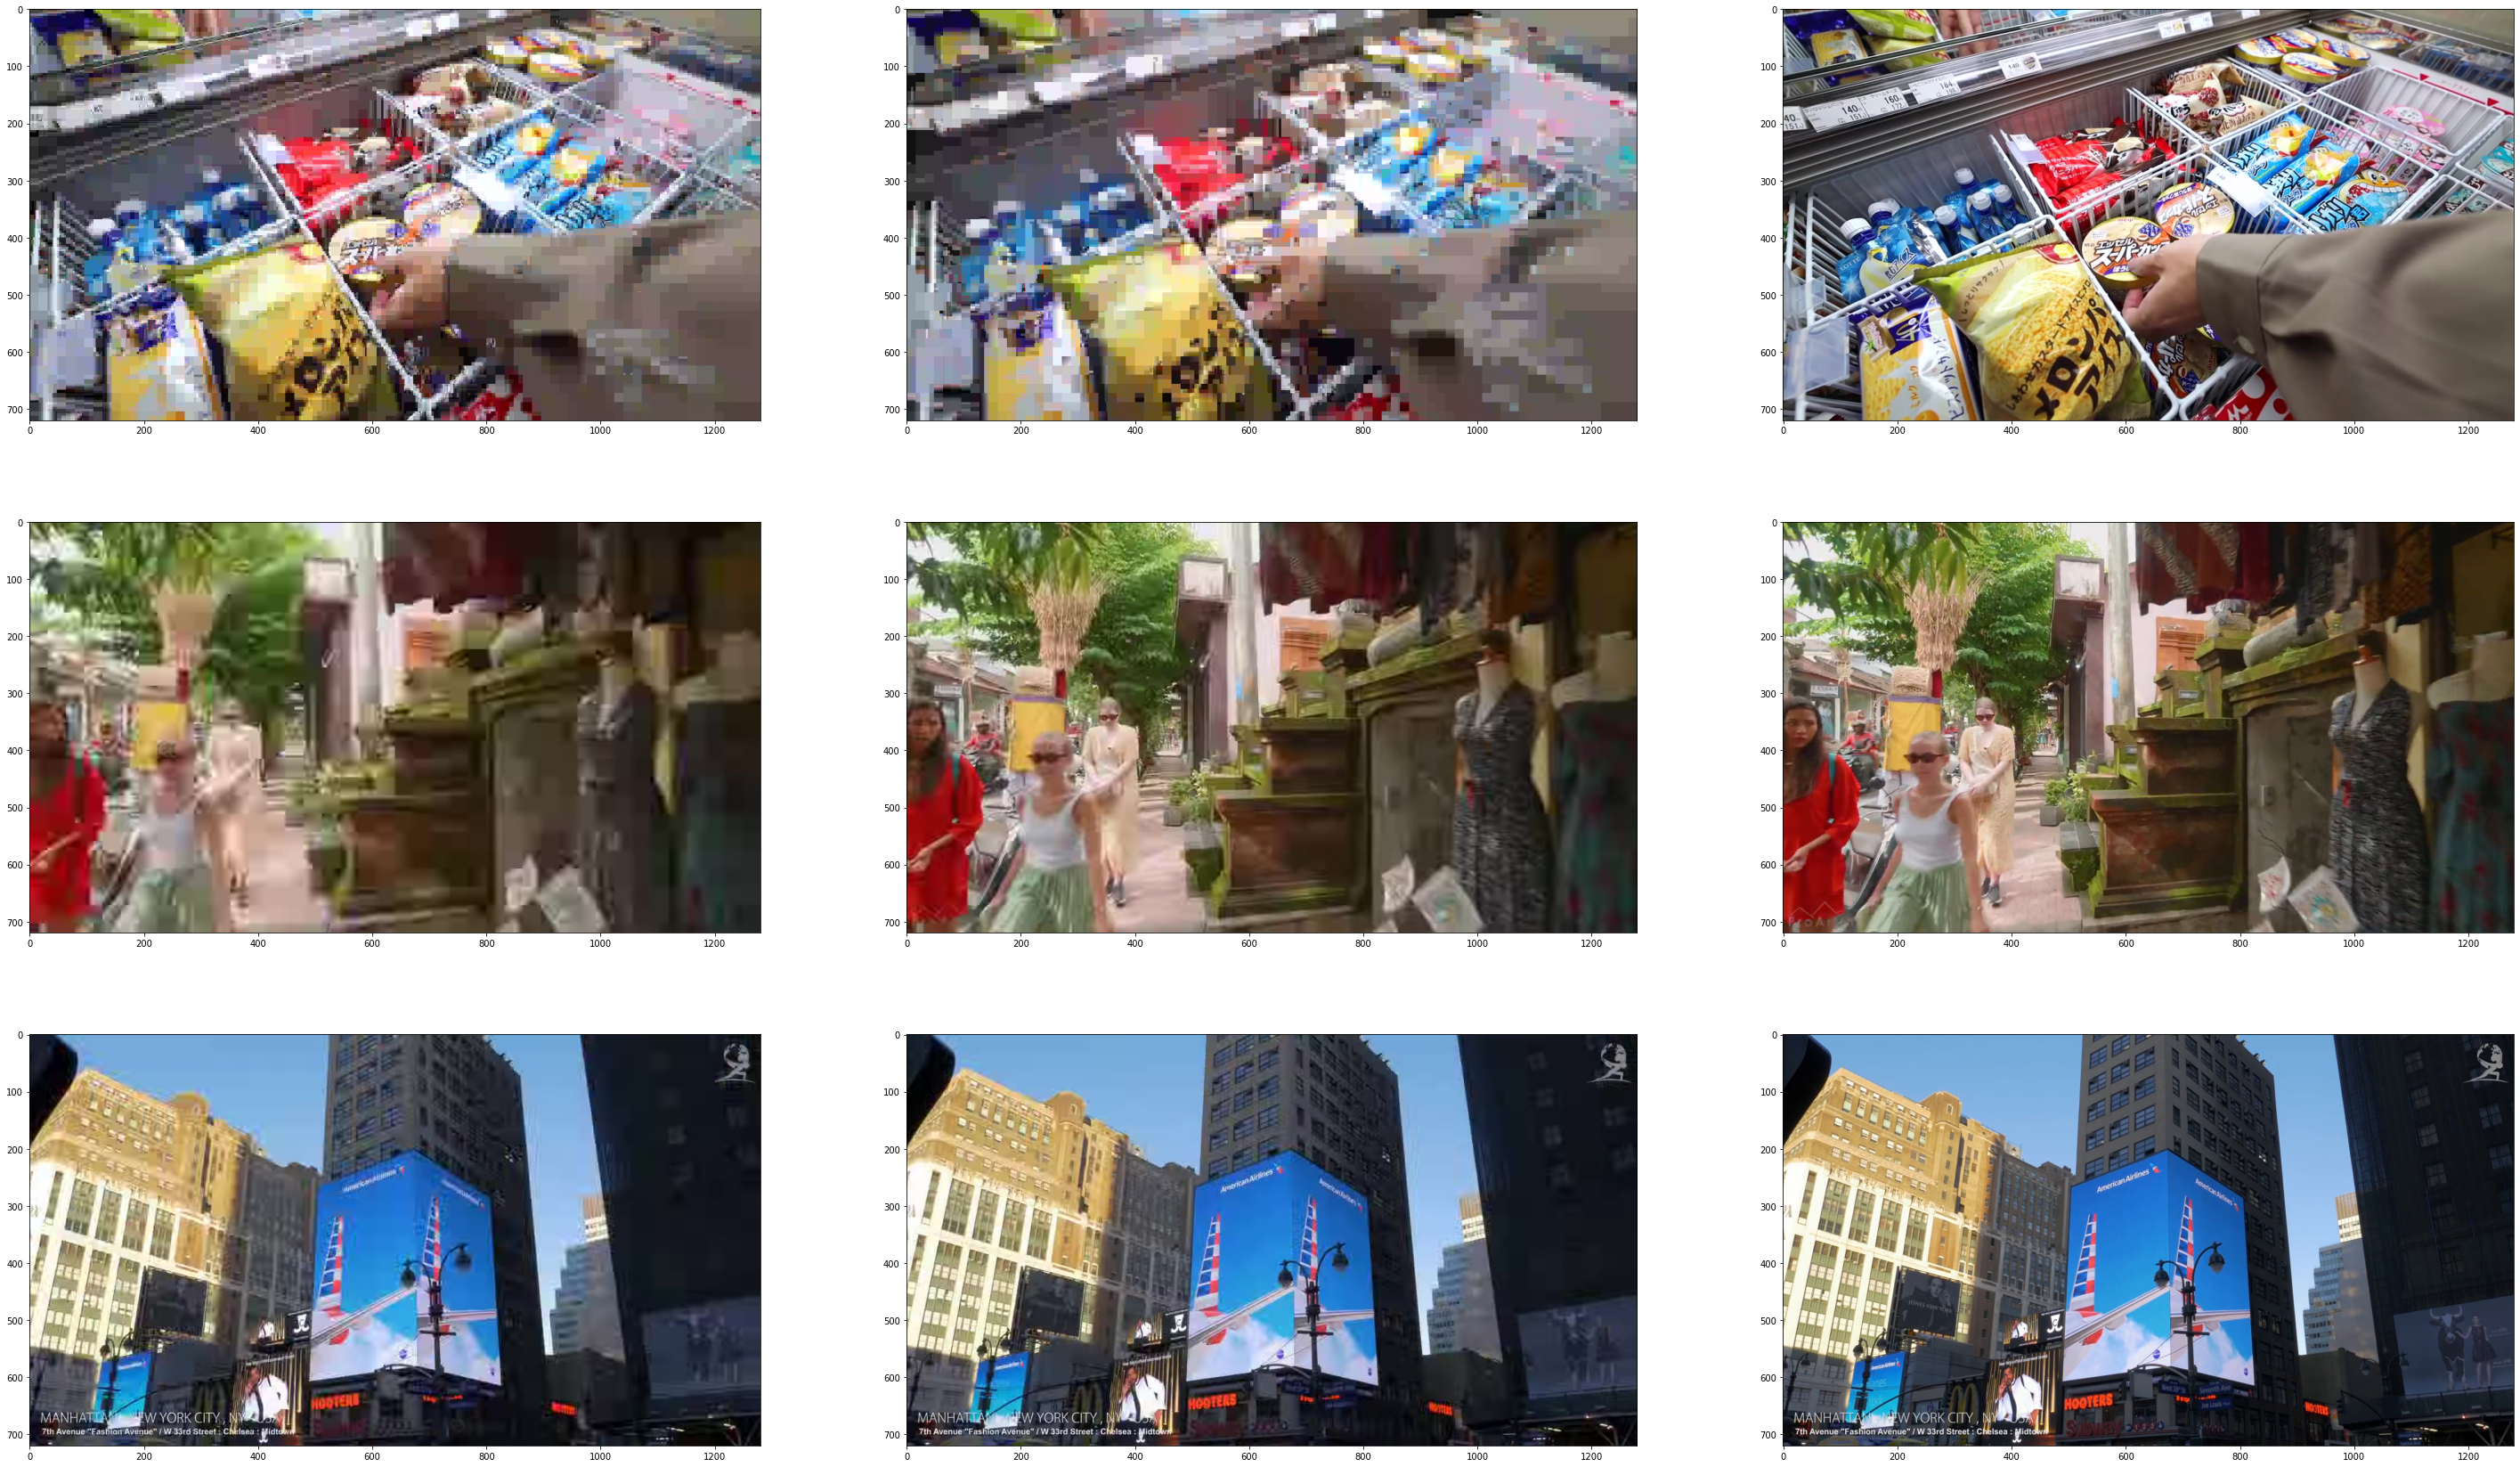

In [4]:
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(50, 30)) # 3 rows and 7 columns of images to be viewed
for row in range(rows):
    seed_image_idx = random.randint(0, m-1) # index of ground truth image which will be displayed
    input_image_idxs = np.random.choice([i for i in range(6)], cols-1, replace=False) # choose cols-1 random augmentations from the 6 made in the dataset
    for col, input_image_idx in enumerate(input_image_idxs): # first 6 columns in each row shows the same input image with different compressions, last column shows the ground truth image
        img = Image.open(input_img_paths[input_image_idx * m + seed_image_idx]) # the way the dataset is formatted allows the same input images to be accessed like this
        axes[row][col].imshow(img)
    gt_img = img = Image.open(target_img_paths[seed_image_idx])
    axes[row][-1].imshow(gt_img)
plt.show()

In [5]:
train_input_paths = []
val_input_paths = []

'''
The input dataset looks like this:
X: [h264_crf_39_images][h264_crf_45_images]...[vp9_crf_63_images] (each [section] of images is length m)
y: [gt_images]

I want to split up the input dataset like this:
X (train): [h264_crf_39_train][h264_crf_45_train]...[vp9_crf_63_train]
X (valid): [h264_crf_39_valid][h264_crf_45_valid]...[vp9_crf_63_valid]
y (train): [gt_images_train] x6 (replicated for each compression type in the input data)
y (valid): [gt_images_valid] x6
'''
for i in range(num_copies):
    # get start, end, and split indexes for each [section] of images
    s_i = m * i
    split_i = s_i + int(m * CV_RATIO)
    e_i = s_i + m
    
    # update the train and validation dataset based on the indexes defined above
    train_input_paths += input_img_paths[s_i:split_i]
    val_input_paths += input_img_paths[split_i:e_i]

# split the ground truth images into train/validation
train_gt_paths = target_img_paths[:int(m * CV_RATIO)]
val_gt_paths = target_img_paths[int(m * CV_RATIO):m]

# replicate the target data to be the same size as the training data
train_gt_paths *= num_copies
val_gt_paths *= num_copies
assert len(train_gt_paths) - len(train_input_paths) == len(val_gt_paths) - len(val_input_paths) == 0 # make sure the datasets are the same length

# shuffle the train/validation datasets such that the train and the target data are shuffled together (so an index accesses an input as well as its corresponding output)
zipped_paths = list(zip(train_input_paths, train_gt_paths))
random.shuffle(zipped_paths)
train_input_paths, train_gt_paths = zip(*zipped_paths)

zipped_paths = list(zip(val_input_paths, val_gt_paths))
random.shuffle(zipped_paths)
val_input_paths, val_gt_paths = zip(*zipped_paths)

### Dataset Class

In [6]:
class ImgDataset(tf.keras.utils.Sequence): # seed code by hhttps://keras.io/examples/vision/oxford_pets_image_segmentation/, modified to perform minor data augmentation
    def __init__(self, input_img_paths, target_img_paths, batch_size=BATCH_SIZE, img_size=IMG_SIZE):
        self.batch_size = batch_size
        self.imgs_per_batch = batch_size // 8 # number of images to load from disk per batch, as each image from disk will be used to make 8 training images
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.imgs_per_batch

    def __getitem__(self, idx):
        s_i = idx * self.imgs_per_batch # get the start index for loading the correct image paths for the specific batch index
        batch_input_img_paths = self.input_img_paths[s_i: s_i + self.imgs_per_batch]
        batch_target_img_paths = self.target_img_paths[s_i: s_i + self.imgs_per_batch]
        
        x = np.zeros((self.batch_size, *self.img_size, 3), np.float32) # return arrays for the input/output images
        y = np.array(x, copy=True)
        
        # random augmentation parameters for the batch, must be applied to the input and target image in the same way
        
        # each loaded image will be FULL_IMG_SIZE dimensions but we need to crop to IMG_SIZE dimensions so set the sampling bounds accordingly
        random_crop_y = np.random.uniform(0, FULL_IMG_SIZE[0]-IMG_SIZE[0], (self.batch_size,)).astype(np.int32)
        random_crop_x = np.random.uniform(0, FULL_IMG_SIZE[1]-IMG_SIZE[1], (self.batch_size,)).astype(np.int32)
        x_flip = np.random.uniform(0, 2, (self.batch_size,)).astype(np.int32) # 0 = no flip, 1 = flip
        
        # load the images from disk, do some data augmentation, place the augmented data into the buffers
        for input_paths, buffer in ((batch_input_img_paths, x), (batch_target_img_paths, y)):
            for i, path in enumerate(input_paths):
                img = np.array(Image.open(path))
                for k in range(8): # augment the loaded image 8 times
                    aug_idx = i*8 + k
                    aug_img = img[ # random crop
                        random_crop_y[aug_idx]:random_crop_y[aug_idx]+IMG_SIZE[0],
                        random_crop_x[aug_idx]:random_crop_x[aug_idx]+IMG_SIZE[1]]
                    if x_flip[aug_idx] == 1: # random x flip
                        aug_img = aug_img[:, ::-1]
                    buffer[aug_idx] = aug_img # store data
            buffer /= 255.0 # normalize data from [0, 255] to [0, 1) for easier model training
        return x, y

### Generator architecture
The generator is basically just a U-Net with more emphasis on upscaling rather than downscaling.

**One important thing about the generator that I never found when doing research in image super-resolution/restoration
was that you should NOT compress the number of numbers to represent an image** (i.e. representing a 20x20x3 \[20\*20\*3 = 1200 numbers\] image as
a 10x10x6 \[10\*10\*6 = 600 numbers\] image).

This is because the model is trying to *add* information to the input image, and not *remove* information. Sounds shockingly obvious,
but nobody told me this and initially I couldn't achieve ANY good results with models with over 3x the parameters and twice the depth
as this one if I neglected this guideline. Parameters ain't everything, y'all.

In [7]:
relu = tf.nn.relu

def gen_gen():
    inputs = Input(shape=(None, None, 3))
    
    up_nf = [32, 128] # number of channels for each upscaling level
    x = Conv2D(up_nf[0]//4, 1, padding="same")(inputs)

    downs = []
    for out_f in up_nf: # downscaling image (via strided convolutions) to distill better representations of the image
        downs.append(x)
        x = Conv2D(out_f, 5, strides=2, padding="same")(relu(x))

    # residual block in the middle of the network
    skip = x
    x = Conv2D(up_nf[-1], 3, padding="same")(relu(x))
    x = Conv2D(up_nf[-1], 3, padding="same")(relu(x))
    x += skip
                     
    for idx, in_f in enumerate(up_nf[::-1]): # upscaling blocks
        out_f = in_f // 4 # you have to do some weird channel/image size magic to get U-Nets to work, but it is what it is
        x = UpSampling2D()(x) # expand the image size from HxW to 2Hx2W
        x = Conv2D(out_f, 1, padding="same")(x) # 1x1 convolution used to change the channel size of the image tensor
        x += downs[-idx-1] # it isn't really a U-Net without some concatenations (I'm using residuals because it's faster)
        
        skip = x # residual blocks instantly make your model better
        x = Conv2D(out_f, 3, padding="same")(relu(x))
        x = Conv2D(out_f, 3, padding="same")(relu(x))
        x += skip

    outputs = Conv2D(3, 1, padding="same")(x) # final convolution with 3 channels representing the 3 color channels for RGB 

    model = Model(inputs, outputs) # wrap it all up into a Model so it can be called
    return model

### Discriminator Architecture

In [8]:
s_lrelu = lambda x: LeakyReLU(0.2)(x) * 1.04**-0.5

def gen_disc():
    inputs = Input(shape=(*IMG_SIZE, 3))
    
    x0 = s_lrelu(Conv2D(64, 3, padding='same')(inputs))
    x1 = s_lrelu(SN(Conv2D(128, 4, strides=2, padding='same', use_bias=False))(x0))
    x2 = s_lrelu(SN(Conv2D(256, 4, strides=2, padding='same', use_bias=False))(x1))
    x3 = s_lrelu(SN(Conv2D(512, 4, strides=2, padding='same', use_bias=False))(x2))

    x3 = UpSampling2D(interpolation='bilinear')(x3)
    x4 = s_lrelu(SN(Conv2D(256, 3, padding='same', use_bias=False))(x3)) + x2
    x4 = UpSampling2D(interpolation='bilinear')(x4)
    x5 = s_lrelu(SN(Conv2D(128, 3, padding='same', use_bias=False))(x4)) + x1
    x5 = UpSampling2D(interpolation='bilinear')(x5)
    x6 = s_lrelu(SN(Conv2D(64, 3, padding='same', use_bias=False))(x5)) + x0
    
    out = s_lrelu(SN(Conv2D(64, 3, padding='same', use_bias=False))(x6))
    out = s_lrelu(SN(Conv2D(64, 3, padding='same', use_bias=False))(out))
    out = Conv2D(1, 3, padding='same')(out)
    
    return Model(inputs, out)

### VGG Feature Extractor Architecture
In Real-ESRGAN [https://arxiv.org/pdf/2107.10833.pdf], they use a VGG-19 network to compare the feature activations from multiple layers of the network 
between the prediction and ground truth images, which gives the model feedback on how similar the prediction image's content is to the ground truth
image rather than raw pixel differences. So, let's make a VGG feature extractor model to do just that!

In [9]:
vgg_layer_idxs = [2, 5, 10, 15, 20] # corresponds to conv_1_2, conv_2_2, conv_3_4, conv_4_4, conv_5_4

def gen_vgg_extractor():
    vgg = kapp.VGG19(
        include_top=False,
        input_shape=(None, None, 3)
    )
    
    outputs = []
    
    for layer_idx in vgg_layer_idxs:
        # get info from the layer's parameters
        layer_kernel = K.get_value(vgg.layers[layer_idx].kernel)
        layer_bias = K.get_value(vgg.layers[layer_idx].bias)
        layer_output_fmaps = layer_kernel.shape[-1] # o in kkio
        layer_output_kernel_shape = layer_kernel.shape[0] # k in kkio
        
        # create a deep copy of the layer which we want to extract, but specify no activation
        extracted_layer = Conv2D(layer_output_fmaps, layer_output_kernel_shape, padding='same', activation='linear')
        extracted_layer(vgg.layers[layer_idx-1].output) # build the kernel so it doesn't get reinitialized witih random values during build time
        K.set_value(extracted_layer.kernel, layer_kernel)
        K.set_value(extracted_layer.bias, layer_bias)
        outputs.append(tf.cast(extracted_layer(vgg.layers[layer_idx-1].output), 'float32'))
    
    vgg_extractor = Model(vgg.input, outputs, name='vgg_extractor')
    vgg_extractor.trainable = False
    
    return vgg_extractor

### GAN Class

In [10]:
class GAN(Model):
    def __init__(self, gen, disc):
        super().__init__()
        self.ema = 0.999
        self.adv_weight = 1.0
        self.generator = gen
        self.ema_generator = clone_model(self.generator)
        self.ema_generator.set_weights(gen.get_weights())
        self.discriminator = disc

    def compile(self, generator_optimizer, discriminator_optimizer, **kwargs):
        super().compile(**kwargs)

        # separate optimizers for the two networks
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    def dra(self, measured_logits, base_logits):
        #return tf.math.sigmoid(measured_logits - tf.reduce_mean(base_logits, axis=0))
        return tf.math.sigmoid(measured_logits - base_logits)
    
    def adversarial_loss(self, real_logits, generated_logits, eps=1e-7):
        dra_real_fake = tf.clip_by_value(tf.reduce_mean(self.dra(real_logits, generated_logits), axis=[1, 2, 3]), eps, 1.0-eps)
        dra_fake_real = tf.clip_by_value(tf.reduce_mean(self.dra(generated_logits, real_logits), axis=[1, 2, 3]), eps, 1.0-eps)
        d_loss = -tf.reduce_mean(tf.math.log(dra_real_fake)) - tf.reduce_mean(tf.math.log(1 - dra_fake_real))
        g_loss = -tf.reduce_mean(tf.math.log(dra_fake_real)) - tf.reduce_mean(tf.math.log(1 - dra_real_fake))
        return d_loss, g_loss
    
    def call(self, inputs):
        return self.ema_generator(inputs)

    def train_step(self, batch):
        deg_images, real_images = batch
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generator(deg_images)
            real_logits = self.discriminator(real_images)
            generated_logits = self.discriminator(generated_images)
            generator_adv_loss, discriminator_loss = self.adversarial_loss(real_logits, generated_logits)
            generator_adv_loss *= self.adv_weight
            generator_vgg_loss = gen_loss(real_images, generated_images)
            generator_loss = generator_vgg_loss + generator_adv_loss

        generator_gradients = tape.gradient(generator_loss, self.generator.trainable_weights)
        discriminator_gradients = tape.gradient(discriminator_loss, self.discriminator.trainable_weights)
        self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_weights))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_weights))

        for weight, ema_weight in zip(self.generator.weights, self.ema_generator.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)
            
        return {'vgg_loss': generator_vgg_loss, 'gen_adv_loss': generator_adv_loss, 'disc_adv_loss': discriminator_loss}
    
    def return_models(self):
        return self.ema_generator, self.discriminator

### Generator FPS Test

In [11]:
def test_fps(duration=10):
    test_img = np.zeros((1, *FULL_IMG_SIZE, 3), dtype='float32') # test the FPS of the model on a full 720p image since that is the image size for the intended use case 
    gen(test_img) # TF calls a lot of functions on just the first call of a model so we don't want to include the time for that in our FPS test
    a = time.time() # start the clock
    frames = 0
    while time.time() - a < duration:
        gen(test_img)
        frames += 1
    return frames / duration

### Loss Functions
This model uses a similar loss to EnhanceNet [https://arxiv.org/pdf/1612.07919v2.pdf], which consists of a content loss between the VGG feature maps
(EnhanceNet uses L2 \[aka MSE\] loss but I'm using L1 \[aka MAE\] loss since that's what ESRGAN uses and it yields better results than EnhanceNet).

EnhanceNet also uses a style loss which incentivizes the model to generate realistic textures. The math for the style loss involves calculating
statistics between VGG feature maps in the form of Gram matrices [https://en.wikipedia.org/wiki/Gram_matrix] of other VGG feature maps and calculating
its L2 loss. The math is kind of beyond me, so I copied the style loss code from [https://github.com/geonm/EnhanceNet-Tensorflow/blob/d0e527418f8b3fd167a61c8777483259d04fc4ab/losses.py#L161].

In [12]:
# From what I've got from reading about this, Gram matrices represent the amount that channels within an image tensor correlate to each other
# (and NOT image locations), which reveals texture information about the image tensor since the Gram matrix only cares about channel information
# further reading article link: https://towardsdatascience.com/neural-networks-intuitions-2-dot-product-gram-matrix-and-neural-style-transfer-5d39653e7916
def gram_matrix(features):
    H = tf.shape(features)[1]
    W = tf.shape(features)[2]
    C = tf.shape(features)[3]
    features = tf.reshape(features, [-1, H * W, C])

    gram_matrix = tf.matmul(features, features, transpose_a=True)
    normalized_gram_matrix = gram_matrix / tf.cast(H * W * C, 'float32')

    return normalized_gram_matrix

def texture_loss_fn(features, patch_size=32): # style loss, patch size refers to the size of the image patches where the Gram matrices are calculated
    H = tf.shape(features)[1]
    W = tf.shape(features)[2]
    C = tf.shape(features)[3]
    
    # split image tensor into patch_size x patch_size sized feature maps
    features = tf.space_to_batch_nd(features, [patch_size, patch_size], [[0, 0], [0, 0]])
    features = tf.reshape(features, [patch_size, patch_size, -1, H // patch_size, W // patch_size, C])
    features = tf.transpose(features, [2, 3, 4, 0, 1, 5])
    patches_gt, patches_pred = tf.split(features, 2, axis=0)

    patches_gt = tf.reshape(patches_gt, [-1, patch_size, patch_size, C])
    patches_pred = tf.reshape(patches_pred, [-1, patch_size, patch_size, C])

    # get them gram matrices
    gram_matrix_gt = gram_matrix(patches_gt)
    gram_matrix_pred = gram_matrix(patches_pred)

    tl_features = tf.reduce_mean(tf.square(gram_matrix_gt - gram_matrix_pred)) # find the L2 loss between the gram matrices
    return tl_features

mae = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.abs(y_pred - y_true)) # L1 loss = mean absolute error (MAE)
def vgg_loss_fn(y_true, y_pred):
    # Keras VGG-19 requires images with ranges [0, 255] to be placed into a preprocessing function which can then be passed into the model
    y_true_preprocessed = kapp.vgg19.preprocess_input(y_true * 255) # [0, 1) * 255 = [0, 255]
    y_pred_preprocessed = kapp.vgg19.preprocess_input(y_pred * 255)
    
    # pass the preprocessed images into the VGG feature extractor
    gt12, gt22, gt34, gt44, gt54 = vgg(y_true_preprocessed)
    p12, p22, p34, p44, p54 = vgg(y_pred_preprocessed)
    cat12, cat22, cat34 = tf.concat([gt12, p12], 0), tf.concat([gt22, p22], 0), tf.concat([gt34, p34], 0) # concatenate feature maps for the texture loss function
    
    # Real-ESRGAN content loss
    vgg_loss = sum((
        0.1 * mae(gt12, p12),
        0.1 * mae(gt22, p22),
        mae(gt34, p34),
        mae(gt44, p44),
        mae(gt54, p54),
    ))
    
    # EnhanceNet style loss
    texture_loss = sum((
        0.3 * texture_loss_fn(cat12),
        texture_loss_fn(cat22),
        texture_loss_fn(cat34),
    ))
    
    return vgg_loss, texture_loss

# combine the content and style loss to form the final generator loss
def gen_loss(y_true, y_pred, vgg_weight=1e-1, texture_weight=2e-6):
    vgg_loss, texture_loss = vgg_loss_fn(y_true, y_pred)
    return vgg_weight * vgg_loss + texture_weight * texture_loss

### Build Datasets and Models

In [13]:
train_gen = ImgDataset(
    train_input_paths, train_gt_paths
)
val_gen = ImgDataset(val_input_paths, val_gt_paths)

In [14]:
gen = gen_gen()
vgg = gen_vgg_extractor()
gen.summary()

2021-12-25 15:25:06.974100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 15:25:07.064265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 15:25:07.064930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 15:25:07.066001: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 8 32          input_1[0][0]                    
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, None, None, 8 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 6432        tf.nn.relu[0][0]                 
_____________________________

In [15]:
# ideally this should run at least 60 FPS to make it run as fast as possible on consumer-grade hardware but sadly it falls short.
# Through some tests, the main factor for the model's inference latency appeared to be the model depth, but the model is already 
# pretty shallow so I'm hesitant to remove some layers to make it faster.
if True and not TRAIN_GAN:
    fps = test_fps()
    print(f'Model ran at {fps} FPS')
else:
    try:
        print(f'Model ran at {fps} FPS')
    except:
        pass

In [16]:
model_dir = '/kaggle/input/models'
model_name = 'mongoly_gen_430K'
#model_name = 'gan'

if PRETRAINED_GAN:
    gen = load_model(os.path.join(model_dir, model_name), custom_objects={'gen_loss': None})
    disc = load_model(os.path.join(model_dir, model_name.replace('_gen_', '_disc_')))
elif PRETRAINED_MODEL:
    gen = load_model(os.path.join(model_dir, model_name), custom_objects={'gen_loss': None})
    disc = gen_disc()

if TRAIN_GAN:
    gan = GAN(gen, disc)

### Compile Models

In [17]:
# A lot of image generation papers (like StyleGAN, SRGAN, and ESRGAN) tend to use Adam optimizers at similar learning rates
gen_opt = Adam(1e-4)

if TRAIN_GAN:
    disc_opt = Adam(1e-4)
    gan.compile(gen_opt, disc_opt)
elif not PRETRAINED_MODEL:
    gen.compile(optimizer=gen_opt, loss=gen_loss)

### Train the Model

2021-12-25 15:25:14.519059: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


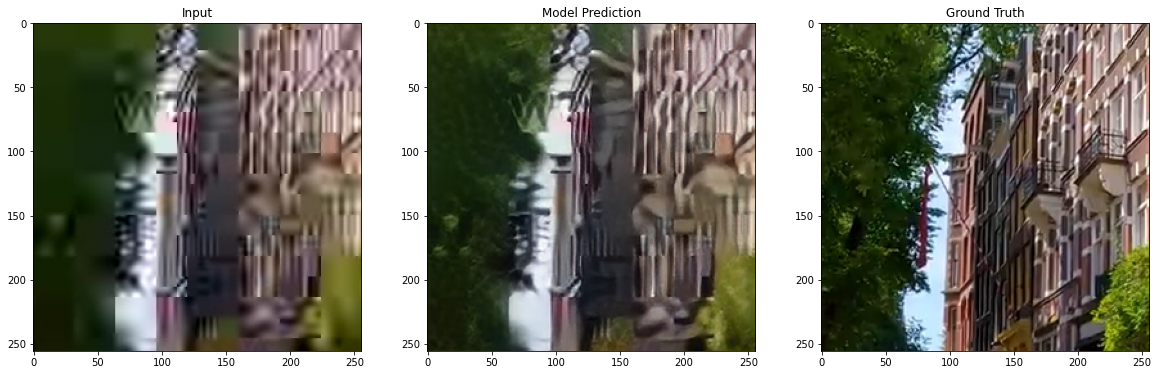

Image loss: 122.36199951171875


2021-12-25 15:25:19.797812: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-25 15:25:29.734131: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  404/16800 [..............................] - ETA: 5:13:41 - vgg_loss: 66.9765 - gen_adv_loss: 4.6951 - disc_adv_loss: 0.5274

2021-12-25 15:33:14.945792: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  770/16800 [>.............................] - ETA: 5:06:39 - vgg_loss: 66.2005 - gen_adv_loss: 4.8845 - disc_adv_loss: 0.4925

In [ ]:
for epoch in range(EPOCHS):
    fig, axes = plt.subplots(1, 3, figsize=(20, 40))
    test_deg_batch, test_gt_batch = random.choice(val_gen)
    test_deg_img, test_gt_img = test_deg_batch[:1], test_gt_batch[:1]
    if TRAIN_GAN:
        pred = gan(test_deg_img)
    else:
        pred = gen(test_deg_img)
    axes[0].imshow(test_deg_img[0])
    axes[0].set_title('Input')
    axes[1].imshow(pred[0])
    axes[1].set_title('Model Prediction')
    axes[2].imshow(test_gt_img[0])
    axes[2].set_title('Ground Truth')
    plt.show()
    print(f'Image loss: {gen_loss(test_gt_img, pred)}')

    if TRAIN_GAN:
        gan.fit(train_gen, validation_data=val_gen)
    else:
        gen.fit(train_gen, validation_data=val_gen)

### Generator Prediction Visualization

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 60))
test_deg_batch, test_gt_batch = random.choice(val_gen)
test_deg_img, test_gt_img = test_deg_batch[:1], test_gt_batch[:1]
if TRAIN_GAN:
    pred = gan(test_deg_img)
else:
    pred = gen(test_deg_img)
axes[0].imshow(test_deg_img[0])
axes[0].set_title('Input')
axes[1].imshow(pred[0])
axes[1].set_title('Model Prediction')
axes[2].imshow(test_gt_img[0])
axes[2].set_title('Ground Truth')
plt.show()
print(f'Image loss: {gen_loss(test_gt_img, pred)}')

### Save Models

In [ ]:
if TRAIN_GAN:
    ema_gen, disc = gan.return_models() 
    ema_gen.save('/kaggle/working/gen_430K')
    disc.save('/kaggle/working/disc_430K')
    %cd /kaggle/working
    !zip -r gan_430K.zip *430K
else:
    gen.save('/kaggle/working/gen_430K')
    %cd /kaggle/working
    !zip -r gen_430K.zip gen_430K